In [1]:
import torch
from torch.nn import *
import torch.nn.functional as F
from pandas_datareader import data as web
import os
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
from utils import *

DEVICE:  cpu


In [3]:
T=30

In [4]:
etfs = ['XLB','XLE','XLF','XLI','XLP','XLV','XLY','XLU']
metrics = ["ATR","Squared_R"]
start = '2001-01-01'
end = '2020-01-01'
start_t = '2022-01-02'
end_t = '2024-01-05'
models = {}
lrs = [0]
hl1 = 50
hl2 = 50

In [5]:
num=2
for file in os.listdir():
    if "runtest" in file:
        num+=1
os.mkdir(f'runtest_{num}')
with open(f'/runtest_{num}/run_data.txt','w') as f:
    f.write(f'Start Training Date: {start} \n End Training Date: {end} \n Start Sim Date: {start_t} \ n End Sim Date: {end_t} \n')
    f.write(f'Model Architecture: \n HL1: {h1}, HL2: {h2} \n')
    f.write(f'Look-back window: {T} days')

for etf in etfs:
    os.mkdir(f'runtest_{num}/{etf}')
for lr in lrs:
    results = pd.DataFrame({"ETF":[],"Metric":[],"Final_Value":[],"Passive_Potential":[]},"Relative_MSE")
    money_df_std = pd.DataFrame()
    money_df_atr = pd.DataFrame()
    money_df_passive = pd.DataFrame()
    for j,etf in enumerate(etfs):
        fig,ax = plt.subplots(1,len(metrics),figsize=(26,6))
        for i,metric in enumerate(metrics):
            scaler = StandardScaler()
            df = get_cleaned_df(etf,start,end)
            #print(df)
            model,fig_tr,fig_te = get_trained_model(df,scaler,metric=metric)
            fig_tr.savefig(f'runtest_{num}/{etf}/training_results_{metric}')
            fig_te.savefig(f'runtest_{num}/{etf}/testing_results_{metric}')
            df_test = get_cleaned_df(etf,start_t,end_t)
            ini_cash = 10000
            final_value, money, shares,passive_value,buy_points,sell_points,preds, t_money,p_money = backtest_strategy(df_test,model,scaler,metric,sell_scale=1,buy_scale=1)
            print(f"{etf} Final Value: {final_value}, Final Money: {money}, Final Shares: {shares}")
            
            if metric=="ATR":
               money_df_atr[etf] = t_money
            elif metric=="SD_Log_Close":
                money_df_std[etf] = t_money
                money_df_passive[f"{etf}_{metric}_Passive"] = p_money

            real_met = np.array(df_test[metric].iloc[T:len(df_test)-1])
            null_model_error = np.sum((real_met-real_met.mean())**2)
            error = np.sum((real_met-preds)**2)/null_model_error
            results.loc[len(results)] = [etf,metric,final_value,passive_value,error]
            sns.lineplot(preds,ax=ax[i],label="Prediction ATR",color="Blue")
            sns.lineplot(real_met,ax=ax[i],label = "True ATR",color="Orange")
            for buy in buy_points:
                ax[i].axvline(buy,color="Green")
            for sell in sell_points:
                ax[i].axvline(sell,color="Red")
            ax[i].set_title(f"{etf} - {metric} | Total Error {error:.2f}")
            #plt.title(f"Performance of LSTM on {etf}")
            fig.savefig(f'runtest_{num}/{etf}/predictions_lr_{lr}.png')
        
        fig_sim,ax_sim = plt.subplots(figsize=(10,3))
        sns.lineplot(x=range(0, len(df_test.index)-(T+1)), y=money_df_atr[etf], label="ATR",ax=ax_sim)
        sns.lineplot(x=range(0,len(df_test.index)-(T+1)),y=money_df_std[etf],label="STD",ax=ax_sim)
        sns.lineplot(x=range(0,len(df_test.index)-(T+1)),y=money_df_passive[f"XLB_SD_Log_Close_Passive"],label="Passive",ax=ax_sim)
        ax_sim.axhline(1000, label = "Initial",color="Black")
        ax_sim.set_title(f"ETF Performance Over Time for {etf}")
        fig_sim.savefig(f"runtest_{num}/{etf}/simulation_perf_lr_{lr}")
    fig2,ax2 = plt.subplots(figsize = (8,6))
    sns.barplot(data=results,x="ETF",y="Final_Value",hue="Metric",ax=ax2)    
    plt.legend(loc=(1.1,1))
    fig2.tight_layout()
    fig2.savefig(f'runtest_{num}/return_metrics_lr_{lr}.png')
    results.to_csv(f'runtest_{num}/overall_results.csv',index=False)

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLB


[*********************100%***********************]  1 of 1 completed


read  1009  lines of data for ticker:  XLB
Number of neg. ATR: 0
On the 316th day, Bought 6.006240017354434 shares for $495.3346142312202
On the 318th day, Bought 3.002392585300191 shares for $246.58650303070468
On the 468th day, Bought 1.0008349316337681 shares for $88.233607572833
On the 470th day, Bought 0.5003751258410919 shares for $44.27319113441981
On the 471th day, Bought 0.5004550140586502 shares for $44.075073088145324
On the 479th day, sold 11.010297674188136 shares for $967.5849596076533
On the 975th day, Bought 6.005579481367907 shares for $486.5720495804278
On the 976th day, Bought 3.0023473322255367 shares for $244.66128410305896
On the 977th day, Bought 1.5011281366845126 shares for $122.56711236029047
On the 978th day, Bought 1.0007965094123745 shares for $82.59573592180327
On the 979th day, Bought 0.5005227391514597 shares for $41.37320961825966
On the 998th day, Bought 0.0 shares for $0.0
On the 999th day, Bought 0.0 shares for $0.0
On the 1000th day, Bought 0.0 shar

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLB


[*********************100%***********************]  1 of 1 completed


read  1009  lines of data for ticker:  XLB
Number of neg. ATR: 0
On the 113th day, Bought 9.000093408040533 shares for $489.7850832655658
On the 372th day, Bought 3.0000118311223583 shares for $245.010966247763
On the 539th day, sold 12.000105239162892 shares for $996.7287411648698
On the 911th day, Bought 7.500030223407435 shares for $607.6524487004704
On the 912th day, Bought 4.0000152272052905 shares for $325.7612401035988
On the 913th day, Bought 1.5000087614831434 shares for $124.11072492511528
On the 975th day, Bought 1.0000018991146773 shares for $81.02015386627114
On the 976th day, Bought 0.5000019401902406 shares for $40.7451581061027
On the 977th day, Bought 0.5000019682552174 shares for $40.8251607080385
On the 978th day, Bought 0.0 shares for $0.0
XLB Final Value: 1304.82285889698, Final Money: 41.817805241944264, Final Shares: 15.000060019656004


[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLE


[*********************100%***********************]  1 of 1 completed


read  1009  lines of data for ticker:  XLE
Number of neg. ATR: 0


[*********************100%***********************]  1 of 1 completed

XLE Final Value: 1000.0, Final Money: 1000, Final Shares: 0.0
read  4779  lines of data for ticker:  XLE



[*********************100%***********************]  1 of 1 completed


read  1009  lines of data for ticker:  XLE
Number of neg. ATR: 0
On the 357th day, Bought 9.000074286398576 shares for $499.414122152257
On the 358th day, Bought 4.000028712124218 shares for $224.40161075016863
On the 447th day, Bought 2.0000197568941442 shares for $116.08114669013614
On the 448th day, Bought 1.0000127942766308 shares for $57.62073720621947
On the 586th day, sold 16.000135549693567 shares for $1244.4905430551657
On the 708th day, Bought 7.500051621820283 shares for $661.0545499472398
On the 757th day, Bought 3.5000373866649914 shares for $315.5633707817156
On the 758th day, Bought 2.0000318419935166 shares for $181.12288361093286
On the 759th day, Bought 1.0000141111625245 shares for $87.98124150007891
On the 764th day, Bought 0.5000062279631825 shares for $45.8605712287831
On the 765th day, Bought 0.0 shares for $0.0
On the 820th day, Bought 0.0 shares for $0.0
On the 821th day, Bought 0.0 shares for $0.0
On the 822th day, Bought 0.0 shares for $0.0
On the 823th day, 

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLF


[*********************100%***********************]  1 of 1 completed


read  1009  lines of data for ticker:  XLF
Number of neg. ATR: 0
On the 725th day, Bought 14.008276414272707 shares for $496.59339888596753
On the 797th day, sold 14.008276414272707 shares for $439.99996217230574
On the 921th day, Bought 13.507909311825399 shares for $465.347475792385
On the 975th day, Bought 6.501651810826545 shares for $228.9881767773109
On the 976th day, Bought 3.5011017938263036 shares for $123.76394841175984
On the 977th day, Bought 1.5005860909128828 shares for $53.39085311468037
On the 978th day, Bought 1.0004467097315843 shares for $35.85601007677999
On the 979th day, Bought 0.5001744510297591 shares for $17.98627325903014


[*********************100%***********************]  1 of 1 completed

XLF Final Value: 1014.6550254752437, Final Money: 18.07382585439201, Final Shares: 26.511870168152477
read  4779  lines of data for ticker:  XLF



[*********************100%***********************]  1 of 1 completed


read  1009  lines of data for ticker:  XLF
Number of neg. ATR: 0
On the 113th day, Bought 21.500307878925252 shares for $492.35705042738823
On the 478th day, sold 21.500307878925252 shares for $830.126887205304
On the 790th day, Bought 18.50005529528391 shares for $666.1869911831736
On the 797th day, sold 18.50005529528391 shares for $581.0867368248677
On the 975th day, Bought 17.500060802335543 shares for $616.3521414582578
On the 976th day, Bought 9.000059184673036 shares for $318.1520921781918
On the 977th day, Bought 4.000017012812093 shares for $142.32060531585427
XLF Final Value: 1322.3448932905653, Final Money: 175.844743467306, Final Shares: 30.500136999820675


[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLI


[*********************100%***********************]  1 of 1 completed


read  1009  lines of data for ticker:  XLI
Number of neg. ATR: 0
On the 135th day, Bought 6.5068293521621134 shares for $467.1903474852397
On the 136th day, Bought 3.5036676055003544 shares for $252.29910427208054
On the 137th day, Bought 1.5022647155584679 shares for $108.49355775763254
On the 138th day, Bought 1.0015541977116174 shares for $71.82145151790007
On the 139th day, Bought 0.5004705858825677 shares for $35.943797478086005
On the 154th day, Bought 0.0 shares for $0.0
On the 155th day, Bought 0.0 shares for $0.0
On the 194th day, Bought 0.0 shares for $0.0
On the 231th day, Bought 0.0 shares for $0.0
On the 232th day, Bought 0.0 shares for $0.0
On the 233th day, Bought 0.0 shares for $0.0
On the 311th day, Bought 0.0 shares for $0.0
On the 312th day, Bought 0.0 shares for $0.0
On the 314th day, Bought 0.0 shares for $0.0
On the 316th day, Bought 0.0 shares for $0.0
On the 317th day, Bought 0.0 shares for $0.0
On the 318th day, Bought 0.0 shares for $0.0
On the 319th day, Boug

[*********************100%***********************]  1 of 1 completed

XLI Final Value: 1535.4489148017203, Final Money: 87.27712023365736, Final Shares: 13.011426725678913
read  4779  lines of data for ticker:  XLI



[*********************100%***********************]  1 of 1 completed


read  1009  lines of data for ticker:  XLI
Number of neg. ATR: 0
On the 112th day, Bought 7.00007972352853 shares for $476.77542996952815
On the 113th day, Bought 3.500031872752536 shares for $231.73711029494538
On the 154th day, Bought 1.500007383945197 shares for $115.44056826842235
On the 155th day, Bought 1.0000051801728804 shares for $78.36040591834691
On the 586th day, sold 13.000124160399144 shares for $1192.8913929582257
On the 886th day, Bought 5.500027267054874 shares for $602.3079860151794
On the 889th day, Bought 3.0000154770966363 shares for $331.4117097548654
On the 975th day, Bought 1.5000065251693626 shares for $158.83569095018382
XLI Final Value: 1311.0279754621674, Final Money: 198.02249178675427, Final Shares: 10.000049269320874


[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLP


[*********************100%***********************]  1 of 1 completed


read  1009  lines of data for ticker:  XLP
Number of neg. ATR: 0
On the 66th day, Bought 8.019838236255202 shares for $480.3883103516866
On the 67th day, Bought 4.00915978478929 shares for $234.4155726166298
On the 68th day, Bought 2.0038797089359552 shares for $117.72793289998737
On the 69th day, Bought 1.0017254202029442 shares for $58.57088531926615
On the 70th day, Bought 0.501189717213848 shares for $29.284515176805137
On the 71th day, Bought 0.5007619062547968 shares for $29.580005802470847
On the 72th day, Bought 0.0 shares for $0.0
On the 73th day, Bought 0.0 shares for $0.0
On the 74th day, Bought 0.0 shares for $0.0
On the 75th day, Bought 0.0 shares for $0.0
On the 76th day, Bought 0.0 shares for $0.0
On the 77th day, Bought 0.0 shares for $0.0
On the 78th day, Bought 0.0 shares for $0.0
On the 79th day, Bought 0.0 shares for $0.0
On the 316th day, Bought 0.0 shares for $0.0
On the 317th day, Bought 0.0 shares for $0.0
On the 318th day, Bought 0.0 shares for $0.0
On the 477t

[*********************100%***********************]  1 of 1 completed

XLP Final Value: 1215.9743498385506, Final Money: 602.0117879067626, Final Shares: 8.50717142762627
read  4779  lines of data for ticker:  XLP



[*********************100%***********************]  1 of 1 completed


read  1009  lines of data for ticker:  XLP
Number of neg. ATR: 0
On the 76th day, Bought 8.500135515340924 shares for $488.84279348725653
On the 79th day, Bought 4.000033337726292 shares for $229.80191525237552
On the 80th day, Bought 2.0000206353828367 shares for $114.84118488368249
On the 81th day, Bought 1.000007730813908 shares for $57.86044730489271
On the 476th day, sold 15.50019721926396 shares for $1095.7089414297693
XLP Final Value: 1204.3626005015622, Final Money: 1204.3626005015622, Final Shares: 0.0


[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLV


[*********************100%***********************]  1 of 1 completed


read  1009  lines of data for ticker:  XLV
Number of neg. ATR: 0
On the 60th day, Bought 5.017857828366045 shares for $477.54952952559654
On the 63th day, Bought 2.5101901940409617 shares for $240.55152629494535
On the 66th day, Bought 1.0038498470185262 shares for $100.20429172938928
On the 67th day, Bought 0.501449514843012 shares for $49.27744382362279
On the 68th day, Bought 0.5015159923863785 shares for $49.32409785120032
On the 69th day, Bought 0.0 shares for $0.0
On the 70th day, Bought 0.0 shares for $0.0
On the 71th day, Bought 0.0 shares for $0.0
On the 72th day, Bought 0.0 shares for $0.0
On the 73th day, Bought 0.0 shares for $0.0
On the 74th day, Bought 0.0 shares for $0.0
On the 75th day, Bought 0.0 shares for $0.0
On the 76th day, Bought 0.0 shares for $0.0
On the 78th day, Bought 0.0 shares for $0.0
On the 207th day, sold 9.534863376654924 shares for $1048.0721823619092
On the 272th day, Bought 4.505516703788875 shares for $525.3432476617828
On the 273th day, Bought 2.5

[*********************100%***********************]  1 of 1 completed

XLV Final Value: 1230.1798165757864, Final Money: 1230.1798165757864, Final Shares: 0.0
read  4779  lines of data for ticker:  XLV



[*********************100%***********************]  1 of 1 completed


read  1009  lines of data for ticker:  XLV
Number of neg. ATR: 0
On the 63th day, Bought 5.000237911979274 shares for $479.17279910497376
On the 64th day, Bought 2.5001058514794567 shares for $243.36030358301034
On the 65th day, Bought 1.0000292660674717 shares for $101.1329596774034
On the 66th day, Bought 0.5000107122777173 shares for $49.91106929956174
On the 67th day, Bought 0.5000107401027023 shares for $49.13605542989255
On the 68th day, Bought 0.0 shares for $0.0
On the 207th day, sold 9.500394481906621 shares for $1044.2833614511758
XLV Final Value: 1121.5701743563338, Final Money: 1121.5701743563338, Final Shares: 0.0


[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLY


In [15]:
os.listdir()

['get_stock_data.ipynb',
 'predictions_lr_0.05.png',
 'predictions_lr_0.png',
 'sim.ipynb',
 'predictions_lr_0.01.png',
 'read_stock_data_from_file.py',
 'testing.ipynb',
 'predictions_lr_0.125.png',
 '__pycache__',
 'full_sim_tests.ipynb',
 'predictions.png',
 'all_etfs_sim.png',
 'predictions_lr_0.5.png',
 'Clean_Data.csv',
 'utils.py',
 'predictions_lr_0.0.png',
 'TSLA.csv',
 'predictions_lr_0.1.png',
 'SPY.csv',
 'planning.txt',
 'return_metrics.png',
 'predictions_lr_0.25.png',
 'predictions_lr_0.375.png',
 'read_and_save_stock_data.py']

In [10]:
results

,ETF,Metric,Final_Value,Passive_Potential
0,XLB,ATR,10002.12,10304.736262
1,XLE,ATR,9158.60,9974.065779
2,XLF,ATR,9105.51,10444.567936
3,XLI,ATR,9086.14,10963.356974
4,XLP,ATR,10118.27,9878.182316
5,XLV,ATR,9988.73,10776.255708
6,XLY,ATR,12520.07,11846.174995
7,XLU,ATR,8284.71,9604.123095
8,XLB,SD_Log_Close,9258.61,10304.736262
9,XLE,SD_Log_Close,10000.00,9974.065779


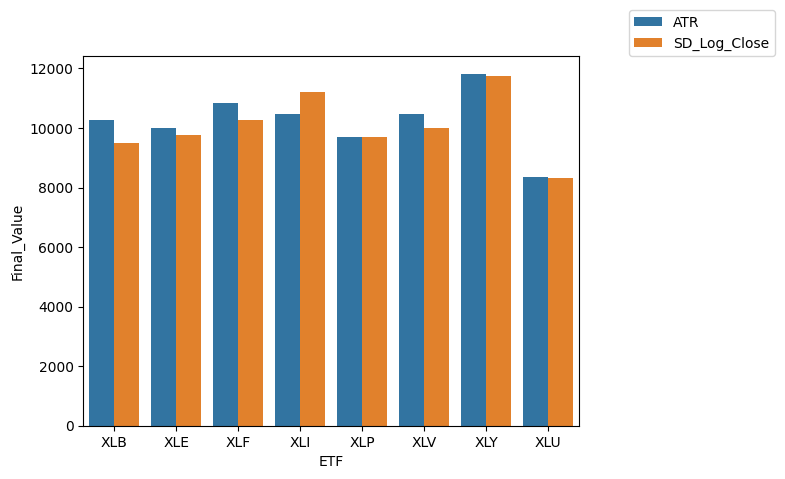

In [6]:
fig2,ax = plt.subplots()
sns.barplot(data=results,x="ETF",y="Final_Value",hue="Metric",ax=ax)
plt.legend(loc=(1.1,1))
fig2.savefig('return_metrics.png')


,XLB_SD_Log_Close_Passive,XLE_SD_Log_Close_Passive,XLF_SD_Log_Close_Passive,XLI_SD_Log_Close_Passive,XLP_SD_Log_Close_Passive,XLV_SD_Log_Close_Passive,XLY_SD_Log_Close_Passive,XLU_SD_Log_Close_Passive
0,9969.403990,10009.430626,9905.529314,9968.479117,9941.144265,9915.641204,10010.309987,9883.477741
1,10014.686085,9865.613580,9924.979161,9945.823483,9859.019984,9842.117483,10003.436662,9710.188228
2,10093.011871,10060.120240,9891.636566,9985.224586,9786.476868,9825.864871,9877.654822,9550.343591
3,10208.052870,10148.532359,9844.401223,10102.442868,9920.613195,9886.231716,9844.662863,9731.102480
4,10353.689879,10286.455263,10000.000000,10211.780930,9928.825623,9996.904264,10056.361262,9896.922617
...,...,...,...,...,...,...,...,...
210,10550.728185,10058.941412,10450.125035,11239.164697,9834.382699,10516.987849,12431.094921,9405.437705
211,10510.341451,9905.693740,10480.689080,11242.119779,9838.488913,10544.075536,12366.485669,9472.662085
212,10468.730877,9883.296004,10447.346485,11228.329393,9859.019984,10554.910611,12290.191766,9460.711085
213,10450.373271,9989.390546,10491.803279,11115.051221,9969.887763,10740.654748,12176.094577,9598.147595


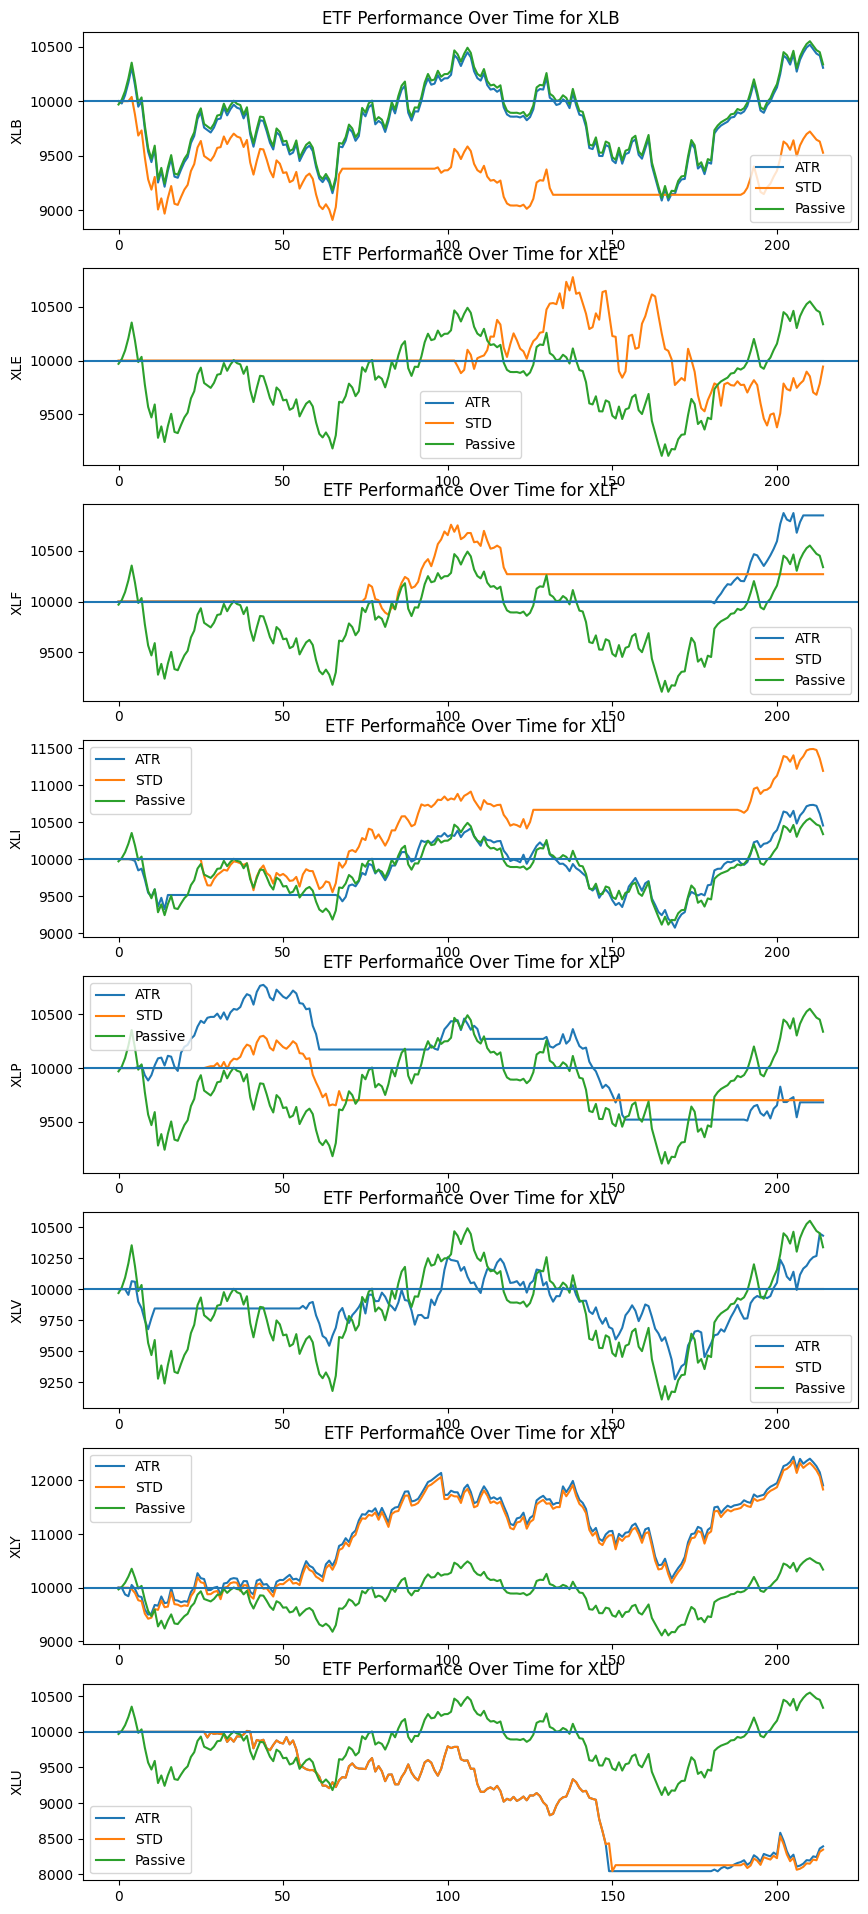

In [14]:
fig3,ax = plt.subplots(len(etfs),1,figsize=(10,24))


for i,etf in enumerate(money_df_atr.columns):
    sns.lineplot(x=range(0, 215), y=money_df_atr[etf], label="ATR", ax=ax[i])
    sns.lineplot(x=range(0,215),y=money_df_std[etf],label="STD",ax=ax[i])
    sns.lineplot(x=range(0,215),y=money_df_passive[f"XLB_SD_Log_Close_Passive"],label="Passive",ax=ax[i])
    ax[i].axhline(10000)
    ax[i].set_title(f"ETF Performance Over Time for {etf}")
plt.legend()  
plt.show()
      




In [10]:
money_df = pd.DataFrame()

money_df['xlb'] = [5,6,7]